In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

rcParams['figure.figsize'] = (10,8)
rcParams['font.size'] = 22

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import lymanAbs as lyA
import buildFluxTables as bft

import linecache
import os
import subprocess
import glob
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [4]:
cosmo.luminosity_distance(z=1.0)
# Matches Ned's calc: The luminosity distance DL is 6560.5 Mpc or 21.398 Gly. 

<Quantity 6560.467651039068 Mpc>

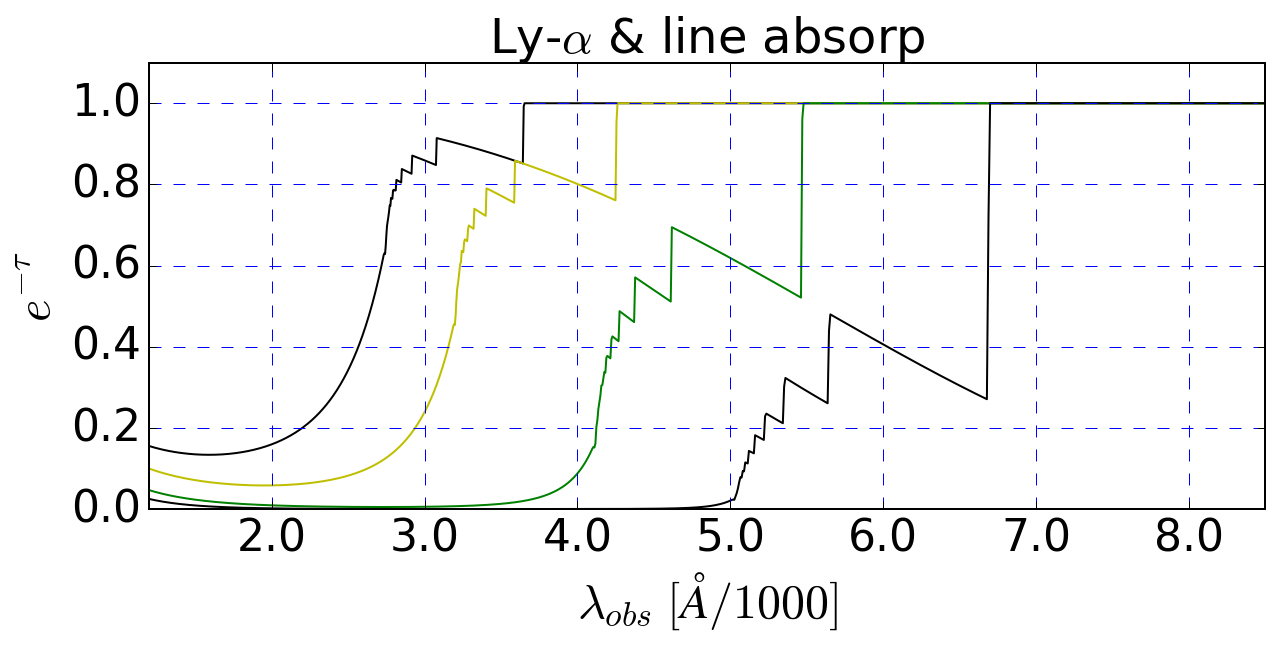

In [5]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTau(2.0)(lamRange),'k-',
        lamRange,lyA.lyTau(2.5)(lamRange),'y-',
        lamRange,lyA.lyTau(3.5)(lamRange),'g-',
        lamRange,lyA.lyTau(4.5)(lamRange),'k-')
ax.set_xlim([1200,8500])
ax.set_ylim([1e-9,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


# Load BC03 data

In [6]:
bcPath =  '/Users/earnric/Research/Research-Observability/Software-Models/for_rick-sethRoot'
bc48MyrZ02 = np.loadtxt(bcPath+"/bc2003_lr_m62_salp_ssp_tau0_0100_dust0_00.48myr",skiprows=6) # 62 -> solar Z

bc48Waveln = bc48MyrZ02[:,0]* u.angstrom
bc48LperA  = bc48MyrZ02[:,1]* 3.826e33 * u.erg / u.second / u.angstrom
bc48freq   = (bc48Waveln[::-1]).to(u.Hz, equivalencies=u.spectral())
bc48LperHz = (bc48LperA * bc48Waveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Let astropy do units...
bc48age = 48.25e6


In [7]:
# REDSHIFT 50 Myr data
z = 5.0
bc48freq = (bc48Waveln[::-1]).to(u.Hz, equivalencies=u.spectral())
bc48LperHz = (bc48LperA * bc48Waveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Let astropy do units...

bc48rsWaveln, bc48rsLperA  = lyA.rsSEDwavelen(bc48Waveln, bc48LperA, z) # Redshift SED in wavelen
bc48rsFreq,   bc48rsLperHz = lyA.rsSEDfreq(bc48freq, bc48LperHz, z)      # Redshift SED in freq

absorb = lyA.lyTau(z)
bc48lyForFluxHz = (bc48rsLperHz * absorb(bc48rsWaveln[::-1]))

# Load SB99 data... 

In [9]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
SB99Path = '/Users/earnric/Research/RAMSES-Data/STARBURST99-runs/' # Home computer dir... 
SB99Dirs = ['padova0004-op/','padova004-op/','padova008-op/','padova02-op/']
# SB99Dirs = ['padova0004/','padova004/','padova008/','padova02/']
Zs       = [0.0004, 0.004, 0.008, 0.02]
SB99FilePat = 'padova*.spectrum1'

# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
for i, (Z, SB99Dir) in enumerate(zip(Zs,SB99Dirs)):
    SB99FilePattern = SB99Path + SB99Dir + SB99FilePat 
    SB99Files   = glob.glob(SB99FilePattern)  # All the files in the dir... should be one!
    if len(SB99Files) != 1:
        print('Error: too many files in an SB99 dir! - ',SB99Path + SB99Dir)
        sys.exit()
    SB99Data    = np.loadtxt(SB99Files[0],skiprows=6)
    # REMEMBER - SB99 data is for 1e6 M_sun
    if i == 0:
        SB990004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 1:
        SB99004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 2:
        SB99008 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 3:
        SB9902 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    # We now have:
    # [[log age, waveln, flux], [], ...]


In [11]:
jwstFilters   = lf.loadJWSTFilters(suppress=True)
hubbleFilters = lf.loadHubbleFilters(suppress=True)
jhkFilters    = lf.loadJHKFilters(suppress=True)

In [11]:
hubbleFilters.keys()

dict_keys(['F775W_ACS', 'F275W_WFC3', 'F160W_WFC3', 'F336W_WFC3', 'F606W_ACS', 'F435W_ACS', 'F225W_WFC3', 'F105W_WFC3', 'F098M_WFC3', 'F850LP_ACS', 'F125W_WFC3'])

In [12]:
np.log10([50e6,100e6,300e6,600e6])

array([ 7.69897   ,  8.        ,  8.47712125,  8.77815125])

In [13]:
np.log10(3e6)

6.4771212547196626

In [14]:
allAges = SB9902[:,0]
wavelns = SB9902[:,1] * u.Angstrom
LperA   = SB9902[:,2] * u.erg / u.second / u.angstrom

age3 = (allAges > 6.47) & (allAges < 6.48)
print(len(allAges[age3]),allAges[age3][0])
age50 = (allAges > 7.685) & (allAges < 7.69)
print(len(allAges[age50]),allAges[age50][0])
age100 = (allAges >= 8.0) & (allAges < 8.0015)
print(len(allAges[age100]))
age300 = (allAges > 8.476) & (allAges < 8.477)
print(len(allAges[age300]))
age600 = (allAges > 8.7771) & (allAges < 8.7773)
print(len(allAges[age600]))

1221 6.47856649559
1221 7.68583127463
1221
1221
1221


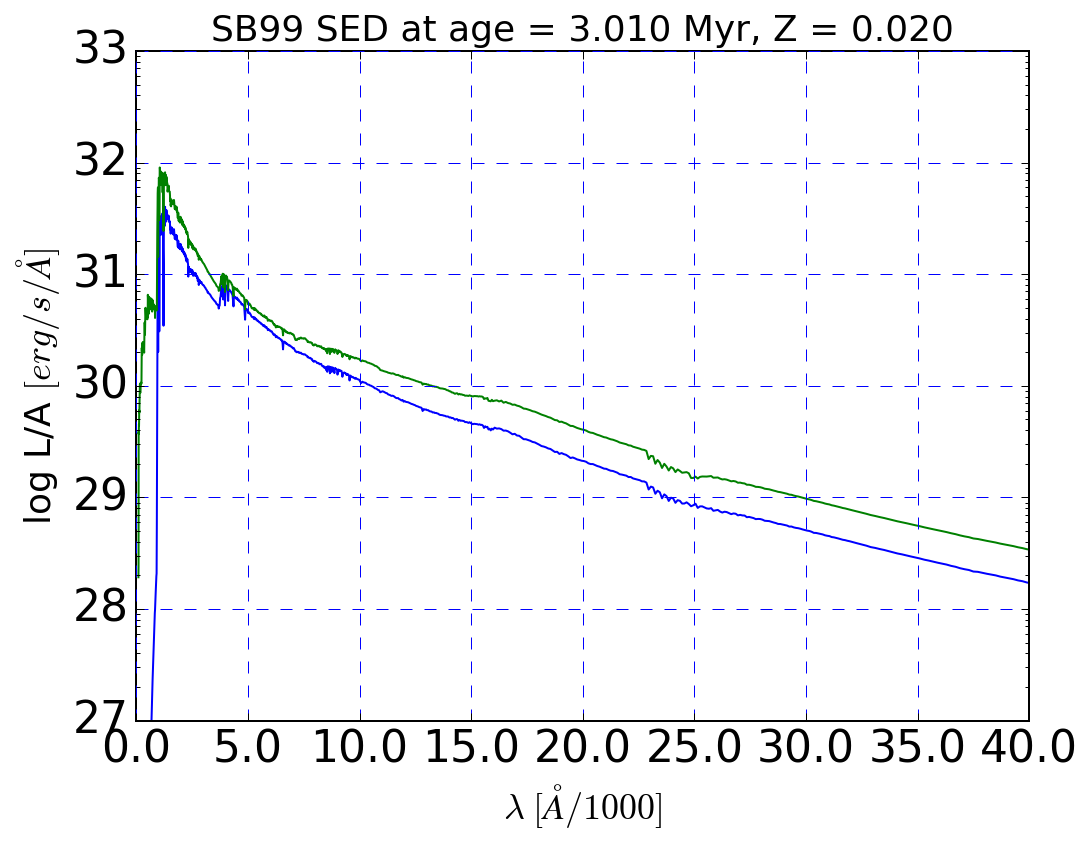

In [27]:
labelsize=18
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xscale('linear')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.plot(wavelns[age50],LperA[age50])
ax.plot(bc48Waveln,bc48LperA)
ax.set_xlim([0.0,4e4])
ax.set_ylim([1e27,1e33])
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_ylabel(r'log L/A $[erg/s/\AA]$', size=labelsize)
ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=labelsize)
ax.set_title('SB99 SED at age = %.3lf Myr, Z = %.3f'%(10**(SB9902[age3][0,0]-6.0), 0.02),size=labelsize)


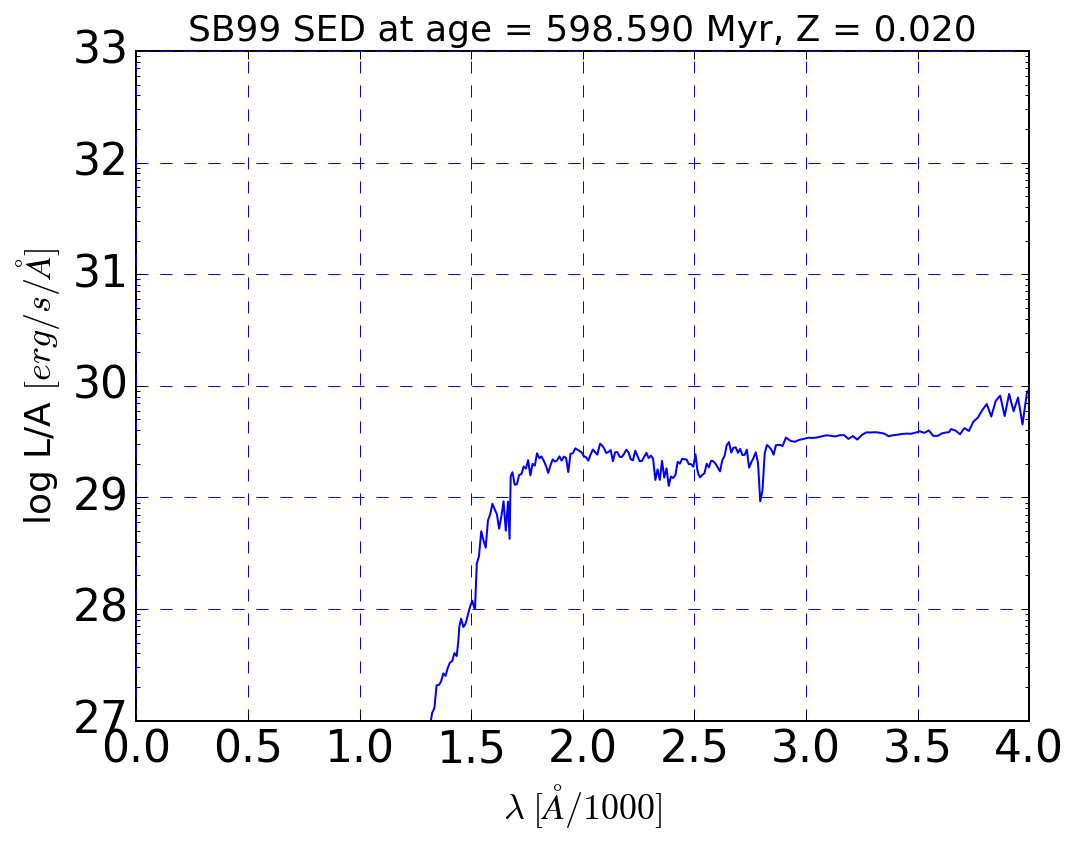

In [30]:
labelsize=18
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xscale('linear')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.plot(wavelns[age600],LperA[age600])
ax.set_xlim([0.0,4e3])
ax.set_ylim([1e27,1e33])
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_ylabel(r'log L/A $[erg/s/\AA]$', size=labelsize)
ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=labelsize)
ax.set_title('SB99 SED at age = %.3lf Myr, Z = %.3f'%(10**(SB9902[age600][0,0]-6.0), 0.02),size=labelsize)


In [14]:
# REDSHIFT 50 Myr data
z = 5.0
freq = (wavelns[age50][::-1]).to(u.Hz, equivalencies=u.spectral())
LperHz = (LperA[age50] * wavelns[age50]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Let astropy do units...

rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[age50], LperA[age50], z) # Redshift SED in wavelen
rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq

absorb = lyA.lyTau(z)
lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))

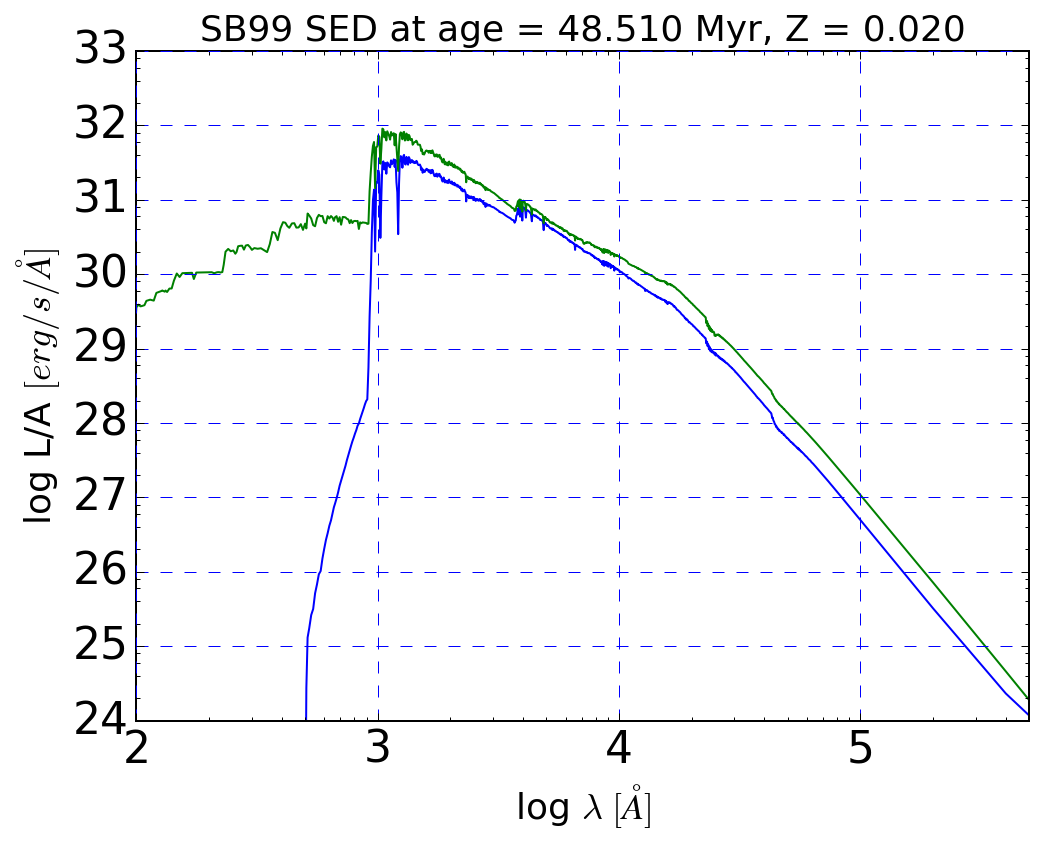

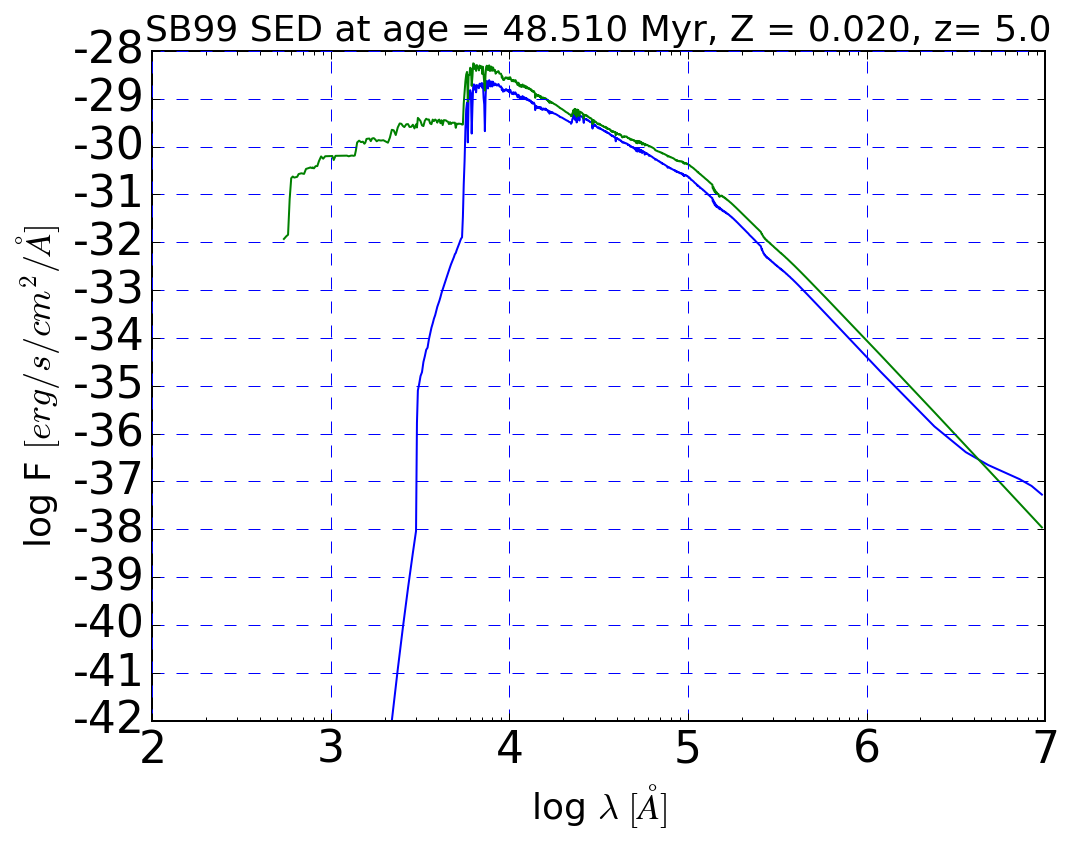

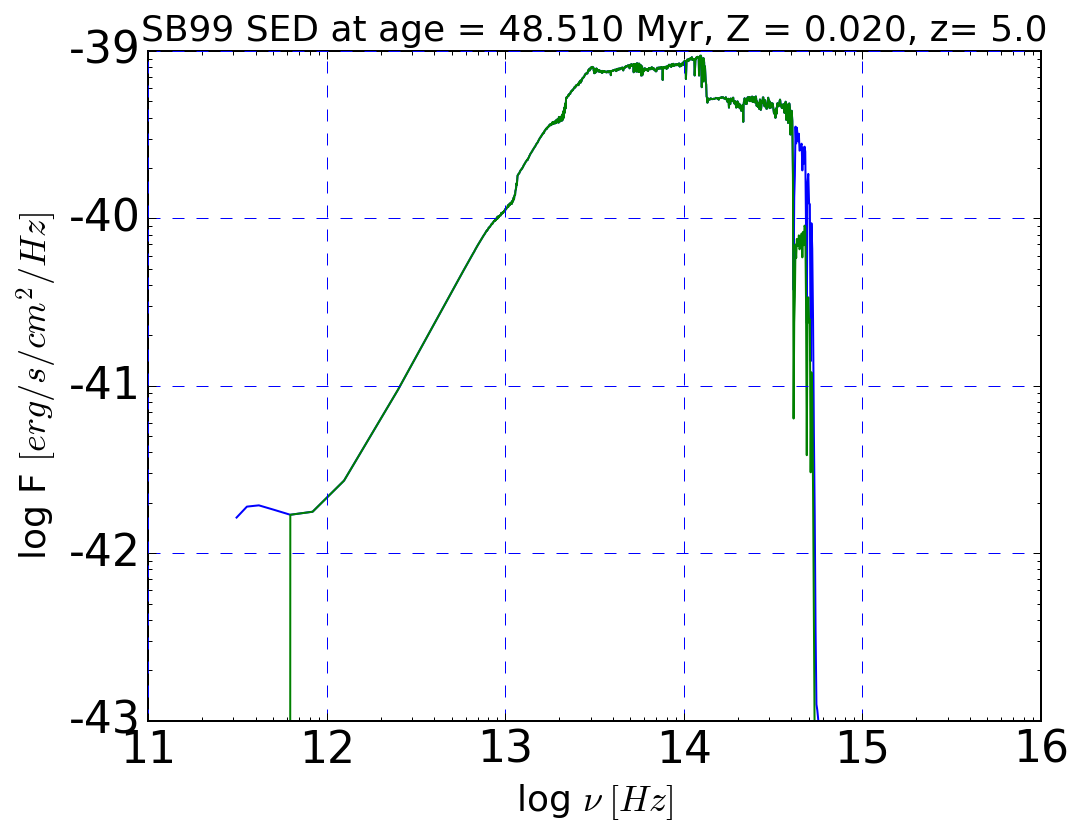

In [15]:
labelsize=18
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.plot(wavelns[age50],LperA[age50])
ax.plot(bc48Waveln,bc48LperA)
ax.set_xlim([100,5e5])
ax.set_ylim([1e24,1e33])
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_ylabel(r'log L/A $[erg/s/\AA]$', size=labelsize)
ax.set_xlabel(r'log $\lambda\; [\AA]$', size=labelsize)
ax.set_title('SB99 SED at age = %.3lf Myr, Z = %.3f'%(10**(SB9902[age50][0,0]-6.0), 0.02),size=labelsize)

labelsize=18
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.plot(rsWaveln,rsLperA)
ax.plot(bc48rsWaveln,bc48rsLperA)
# ax.set_xlim([100,5e5])
ax.set_ylim([1e-42,1e-28])
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_ylabel(r'log F $[erg/s/cm^2/\AA]$', size=labelsize)
ax.set_xlabel(r'log $\lambda\; [\AA]$', size=labelsize)
ax.set_title('SB99 SED at age = %.3lf Myr, Z = %.3f, z= %.1f'%(10**(SB9902[age50][0,0]-6.0), 0.02,z),size=labelsize)

labelsize=18
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.plot(rsFreq,rsLperHz)
ax.plot(rsFreq,lyForFluxHz)
# ax.set_xlim([100,5e5])
ax.set_ylim([1e-43,1e-39])
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_ylabel(r'log F $[erg/s/cm^2/Hz]$', size=labelsize)
ax.set_xlabel(r'log $\nu\; [Hz]$', size=labelsize)
ax.set_title('SB99 SED at age = %.3lf Myr, Z = %.3f, z= %.1f'%(10**(SB9902[age50][0,0]-6.0), 0.02,z),size=labelsize)



# Check my flux files against Seth's

In [7]:
# Load Seth's data

In [8]:
#
# Load Seth's data for F160W at z = 2
# Look for age ~25.118 Myr to compare to my flux... 
# PADOVA data 1994
#
sethPath = '/Users/earnric/Research/Research-Observability/Software-Models/sethData/'
sethFile160z2 = sethPath + 'F160W_WFC3_bc_2.00' # IDL Save file
seth160z2Data = readsav(sethFile160z2)
seth160z2Data.keys()

dict_keys(['tau', 'filtfluxz', 'av', 'wave', 'age'])

In [9]:
#### z = 7.0
sethFile160z7 = sethPath + 'F160W_WFC3_bc_7.00' # IDL Save file
seth160z7Data = readsav(sethFile160z7)
seth160z7Data.keys()

dict_keys(['tau', 'filtfluxz', 'av', 'wave', 'age'])

In [12]:
flux = (np.trapz(hubbleFilters['F160W_WFC3'](rsWaveln[::-1])*lyForFluxHz/rsFreq,rsFreq)) / \
                np.trapz(hubbleFilters['F160W_WFC3'](rsWaveln[::-1])/rsFreq,rsFreq)

print("Flux in F160W_WFC3 = {:.3e} at z = {}".format(flux,z))

NameError: name 'rsWaveln' is not defined

In [44]:
jwstFilters.keys(),hubbleFilters.keys()

(dict_keys(['f090w', 'f356w', 'f200w', 'f444w', 'f480m', 'f210m', 'f360m', 'f430m', 'f277w', 'f335m', 'f070w', 'f140m', 'f300m', 'f150w', 'f162m', 'f410m', 'f250m', 'f115w', 'f182m', 'f460m']),
 dict_keys(['F850LP_ACS', 'F125W_WFC3', 'F336W_WFC3', 'F105W_WFC3', 'F225W_WFC3', 'F160W_WFC3', 'F435W_ACS', 'F275W_WFC3', 'F606W_ACS', 'F098M_WFC3', 'F775W_ACS']))

In [13]:
myTabSB99 = np.genfromtxt('SB9902_5.0.gz',delimiter=',',names=True, comments='#')

In [14]:
myTabSB99.dtype.names

('LogAge',
 'redshift',
 'f115w',
 'f150w',
 'f430m',
 'f090w',
 'f360m',
 'f140m',
 'f444w',
 'f410m',
 'f182m',
 'f200w',
 'f162m',
 'f460m',
 'f335m',
 'f070w',
 'f480m',
 'f277w',
 'f356w',
 'f210m',
 'f250m',
 'f300m',
 'F125W_WFC3',
 'F105W_WFC3',
 'F275W_WFC3',
 'F775W_ACS',
 'F098M_WFC3',
 'F850LP_ACS',
 'F435W_ACS',
 'F160W_WFC3',
 'F606W_ACS',
 'F336W_WFC3',
 'F225W_WFC3',
 'H',
 'Ks',
 'J')

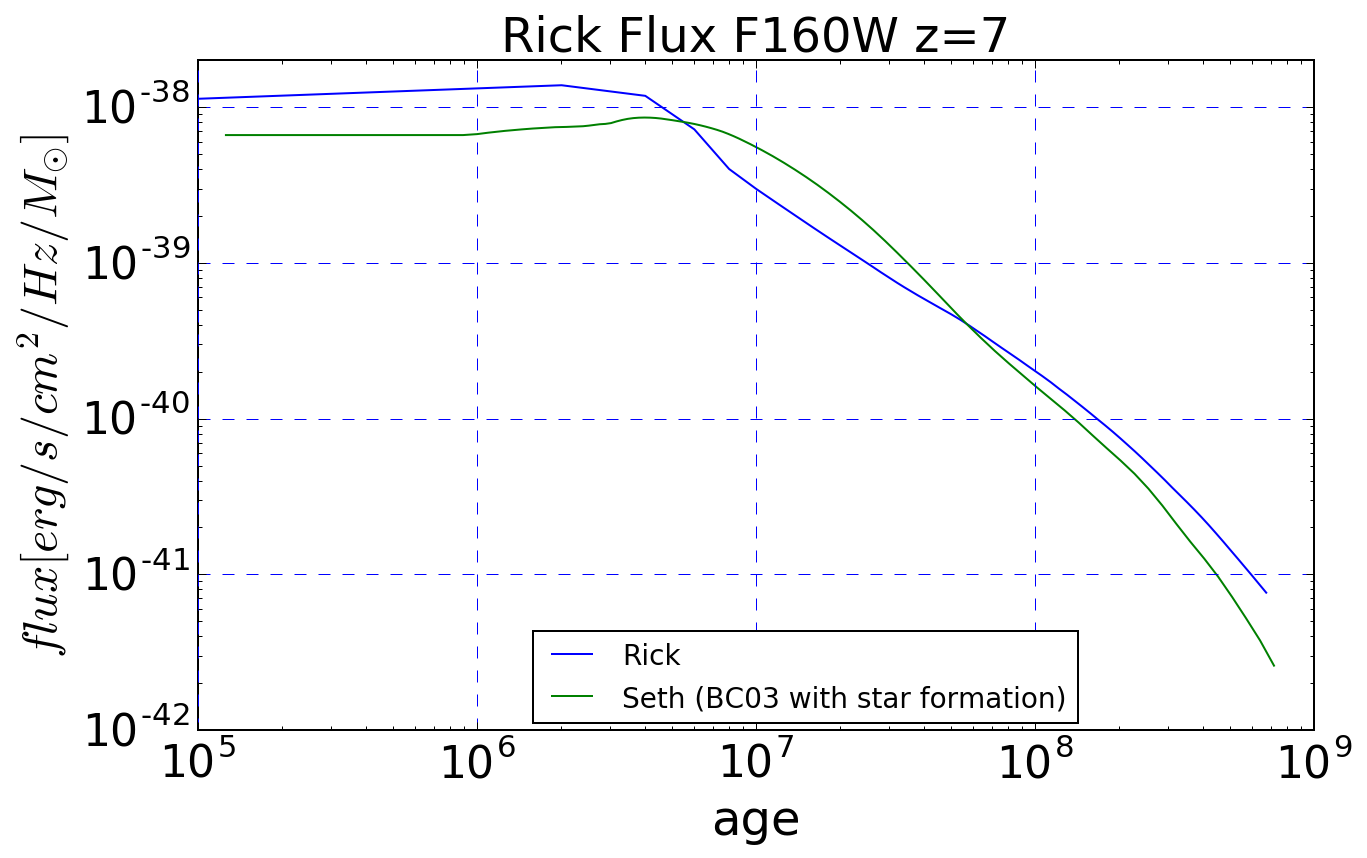

In [15]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(10**myTabSB99['LogAge'],myTabSB99['F160W_WFC3'],
       seth160z7Data['age'],seth160z7Data['filtfluxz'][0][0])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e5,1e9])
ax.set_ylim([1e-42,2e-38])
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Rick Flux F160W z=7',size=labelsize)
ax.legend(['Rick','Seth (BC03 with star formation)'],
              loc=(0.3,0.01), fontsize=14 )


In [16]:
myTabSB99z2 = np.genfromtxt('SB9902_2.0.gz',delimiter=',',names=True, comments='#')

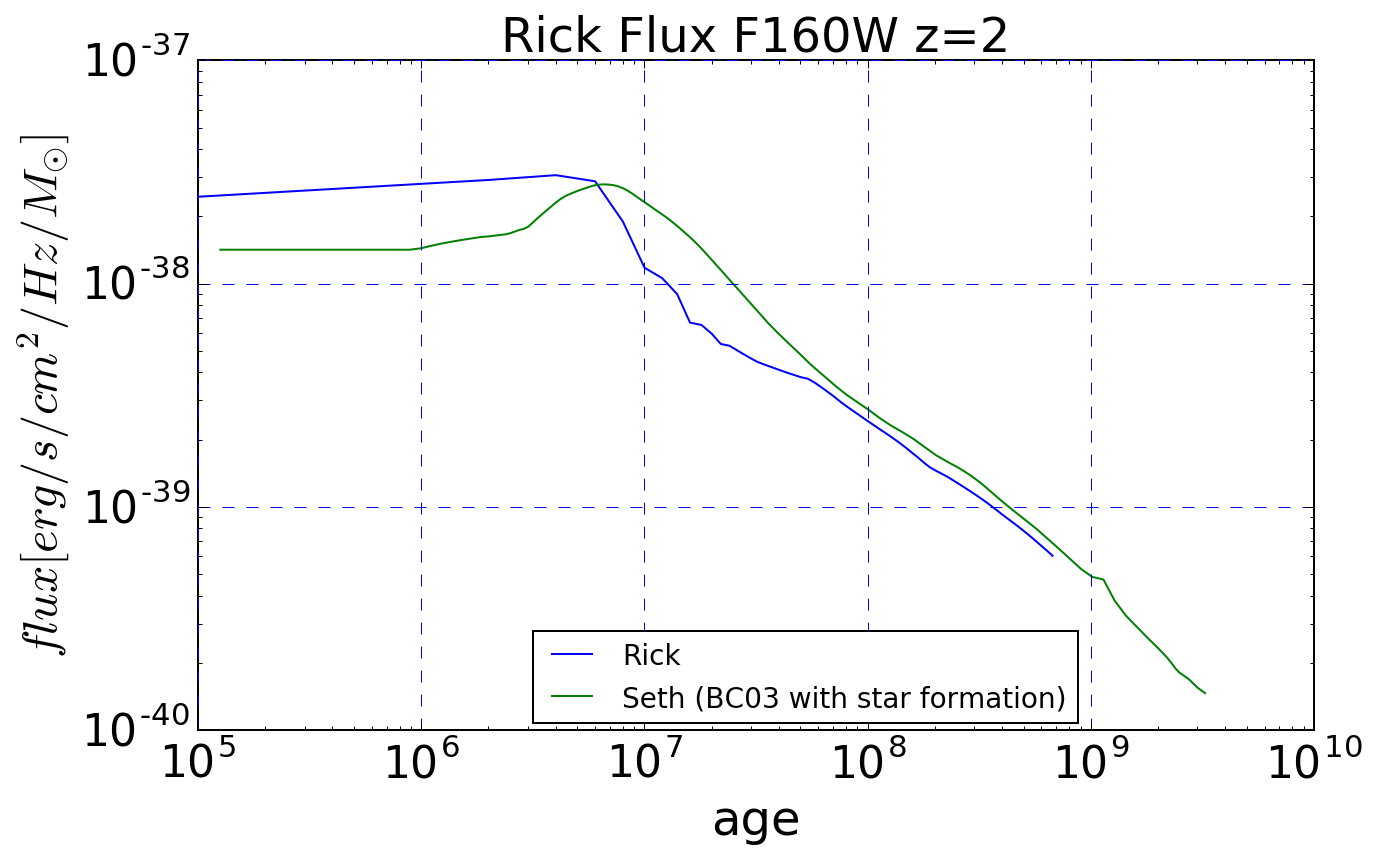

In [17]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(10**myTabSB99z2['LogAge'],myTabSB99z2['F160W_WFC3'],
       seth160z2Data['age'],seth160z2Data['filtfluxz'][0][0])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e5,1e10])
ax.set_ylim([1e-40,1e-37])
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Rick Flux F160W z=2',size=labelsize)
ax.legend(['Rick','Seth (BC03 with star formation)'],
              loc=(0.3,0.01), fontsize=14 )


In [18]:
myTabSchz2 = np.genfromtxt('Zem5_2.0.gz',delimiter=',',names=True, comments='#')

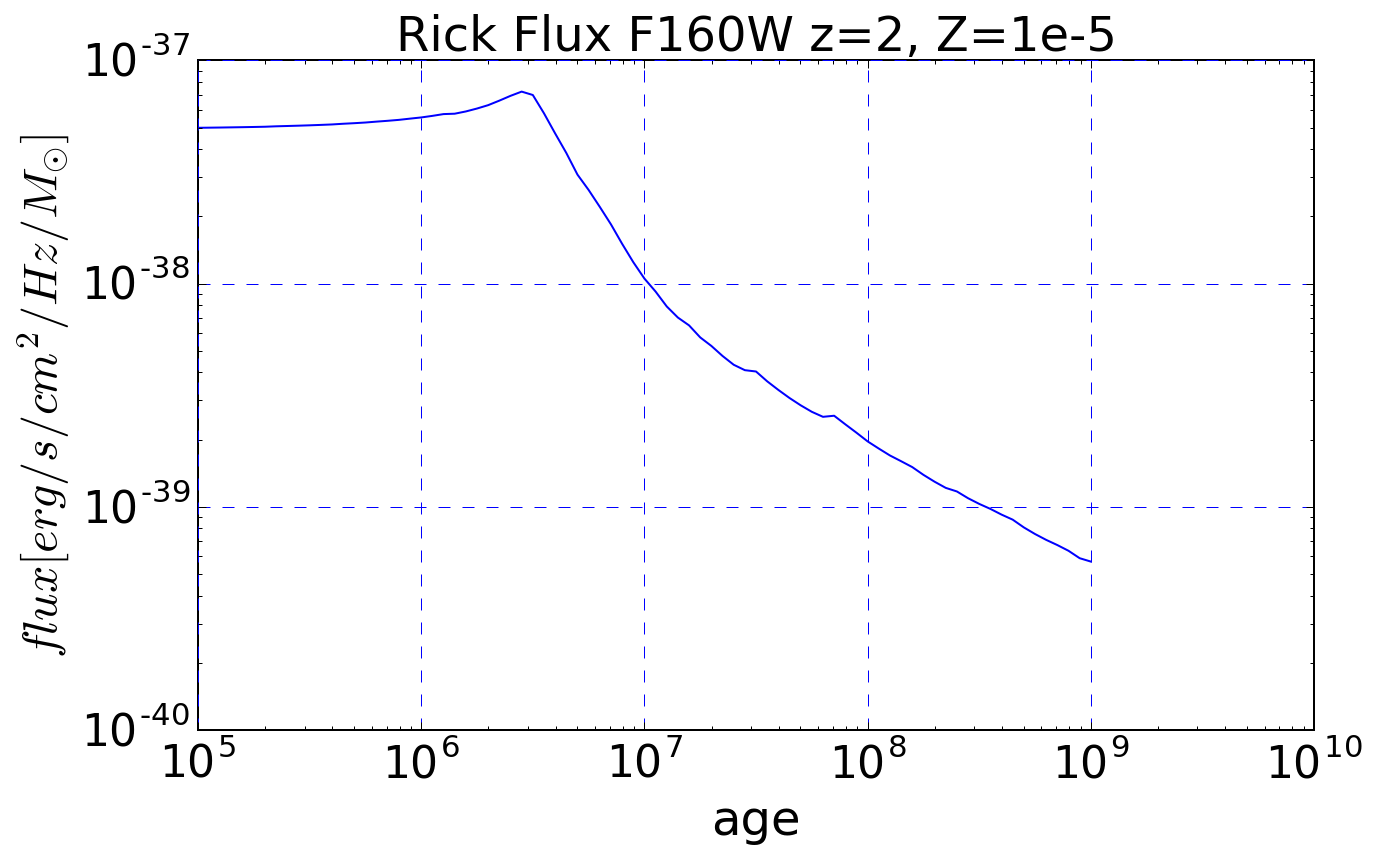

In [19]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(10**myTabSchz2['LogAge'],myTabSchz2['F160W_WFC3'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e5,1e10])
ax.set_ylim([1e-40,1e-37])
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Rick Flux F160W z=2, Z=1e-5',size=labelsize)
